In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from datetime import timedelta

In [7]:
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (14, 6)

model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")
X_train = pd.read_csv('X_train.csv', index_col='date', parse_dates=True)
training_columns = X_train.columns.tolist()

In [13]:
df = pd.read_csv("bitcoin_data.csv", parse_dates=["date"], index_col="date")
df = df.sort_index()
print(f"ℹ️ Historical data shape: {df.shape}")

ℹ️ Historical data shape: (335, 20)


In [9]:
N_DAYS = 30
print(f"\n📆 Forecasting the next {N_DAYS} days...")


📆 Forecasting the next 30 days...


In [14]:
future_df = df.copy()
future_predictions = []

# 6. Forecasting loop
for step in range(N_DAYS):
    last_known = future_df.iloc[-1:]
    next_date = last_known.index[0] + timedelta(days=1)

    # Create new row
    next_row = last_known.copy()
    next_row.index = [next_date]

    # Combine into temporary frame
    window_df = pd.concat([future_df, next_row])

    # Feature engineering
    window_df['lag_1'] = window_df['price'].shift(1)
    window_df['lag_2'] = window_df['price'].shift(2)
    window_df['lag_3'] = window_df['price'].shift(3)
    window_df['lag_5'] = window_df['price'].shift(5)
    window_df['lag_7'] = window_df['price'].shift(7)
    window_df['ma_7'] = window_df['price'].rolling(7).mean()
    window_df['ma_30'] = window_df['price'].rolling(30).mean()
    window_df['momentum_7'] = window_df['price'] - window_df['price'].shift(7)
    window_df['momentum_30'] = window_df['price'] - window_df['price'].shift(30)
    window_df['pct_change_1d'] = window_df['price'].pct_change(periods=1) * 100
    window_df['pct_change_7d'] = window_df['price'].pct_change(periods=7) * 100
    window_df['daily_return'] = window_df['price'].pct_change() * 100
    window_df['volatility_7'] = window_df['daily_return'].rolling(7).std()
    window_df['volatility_30'] = window_df['daily_return'].rolling(30).std()

    if 'volume' in df.columns:
        window_df['volume'] = window_df['volume'].ffill()

    # Extract the final row
    row = window_df.iloc[-1:][training_columns]

    if row.isnull().values.any():
        print(f"⚠️ Step {step+1} skipped due to missing values in features.")
        break

    # Scale and restore feature names
    row_scaled = scaler.transform(row)
    row_scaled_df = pd.DataFrame(row_scaled, columns=training_columns, index=row.index)

    # Predict
    pred_price = model.predict(row_scaled_df)[0]
    future_predictions.append((next_date, pred_price))

    # Append prediction to future_df for next step
    predicted_row = last_known.copy()
    predicted_row['price'] = pred_price
    if 'volume' in df.columns:
        predicted_row['volume'] = last_known['volume'].values[0]
    future_df.loc[next_date] = predicted_row.iloc[0]

✅ Forecast saved to future_predictions.csv


C:\Users\lenovo\AppData\Local\Temp\ipykernel_3612\3615242214.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


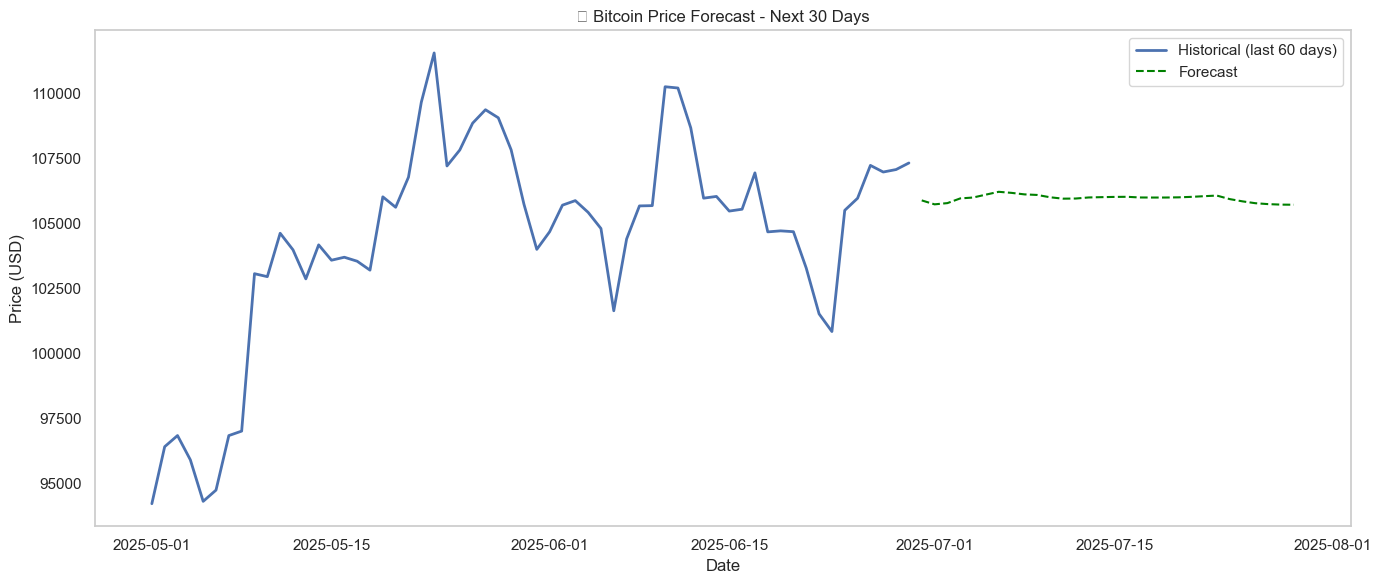

In [15]:
if future_predictions:
    pred_dates, pred_prices = zip(*future_predictions)
    forecast_df = pd.DataFrame({'predicted_price': pred_prices}, index=pd.to_datetime(pred_dates))
    forecast_df.to_csv("future_predictions.csv")
    print("✅ Forecast saved to future_predictions.csv")

    # 8. Plot
    plt.plot(df['price'].iloc[-60:], label='Historical (last 60 days)', linewidth=2)
    plt.plot(forecast_df.index, forecast_df['predicted_price'], label='Forecast', linestyle='--', color='green')
    plt.title(f"📈 Bitcoin Price Forecast - Next {N_DAYS} Days")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    print("❌ Forecast failed — no valid predictions were made.")